In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.5, 0.5],
    c1 = 2.0,
    c2 = 2.0,
    w = 1.2,
    w_decay = 0.95,
    scale_hyperparameter = False))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 3
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 100, Accuracy: 0.8765432098765432, Loss: 0.695604818838614
Checkpoint 200, Accuracy: 0.8765432098765432, Loss: 0.695604818838614
Checkpoint 300, Accuracy: 0.8765432098765432, Loss: 0.695604818838614
Checkpoint 400, Accuracy: 0.8765432098765432, Loss: 0.695604818838614
Checkpoint 500, Accuracy: 0.8765432098765432, Loss: 0.695604818838614


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for y in y_list:
        ax.plot(x, y)
    if x_label is not None and y_label is not None and title is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title=title)
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

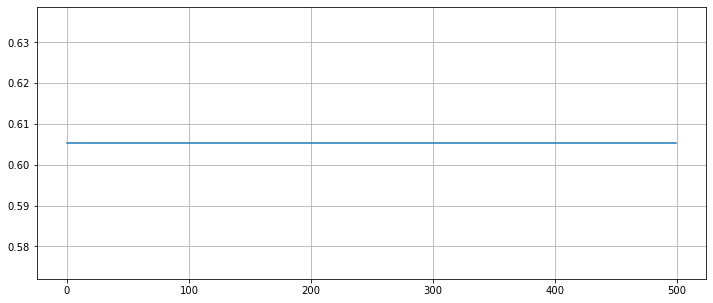

In [10]:
draw_plot(x = [i for i in range(len(history))], y_list = [history], x_label = 'Epochs', \
    y_label = model.loss_fn)

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [9.7380877e-01 3.7717487e-04 2.5814069e-02]
[1. 0. 0.] <-> [0.81906426 0.02952303 0.15141273]
[0. 1. 0.] <-> [0.86932623 0.00197006 0.12870371]
[1. 0. 0.] <-> [0.9589556  0.00183088 0.0392135 ]
[1. 0. 0.] <-> [0.9371871  0.00506355 0.05774931]
[1. 0. 0.] <-> [0.64109486 0.13209607 0.22680901]
[1. 0. 0.] <-> [0.5624626  0.12960884 0.30792847]
[0. 1. 0.] <-> [0.2348577  0.38572827 0.379414  ]
[0. 1. 0.] <-> [0.84135646 0.00226911 0.15637441]
[1. 0. 0.] <-> [9.5643353e-01 8.8010798e-04 4.2686373e-02]
[1. 0. 0.] <-> [0.97377986 0.00219652 0.02402362]
[1. 0. 0.] <-> [0.8530886  0.02367759 0.12323377]
[1. 0. 0.] <-> [0.8020636 0.0027107 0.1952257]
[1. 0. 0.] <-> [0.94110835 0.00396536 0.05492632]
[1. 0. 0.] <-> [0.9202305  0.00936514 0.07040438]
[1. 0. 0.] <-> [0.91784644 0.03409343 0.04806012]
[1. 0. 0.] <-> [0.96748817 0.00112123 0.03139059]
[1. 0. 0.] <-> [0.8629803  0.02531606 0.11170364]
[0. 1. 0.] <-> [0.24023919 0.38138103 0.37837976]
[1. 0. 0.] <-> [0.95419884 0.001157

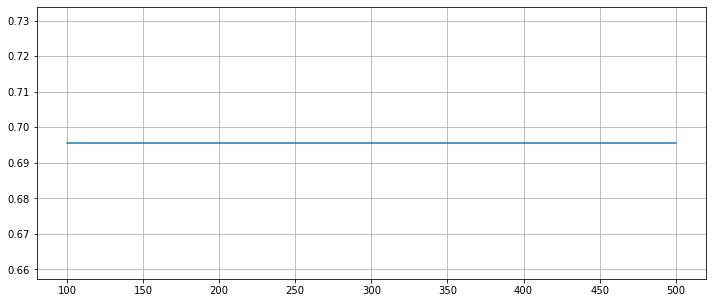

In [12]:
cat_cross = [ ckp[model.loss_fn] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [cat_cross], x_label = 'Checkpoints', \
    y_label = model.loss_fn)

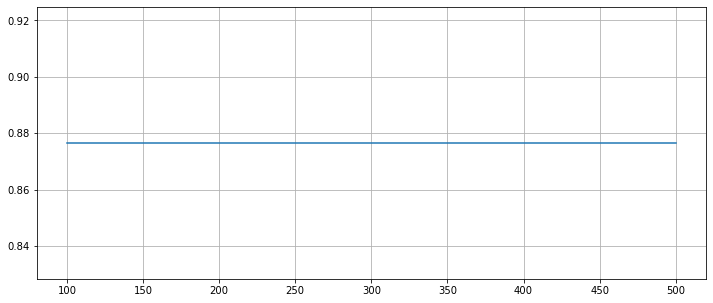

In [13]:
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[ 0.88760313  1.60027872 -2.97477507  0.09779704 -2.17220445]
 bias: -0.1631788554750182

Neuron 1: weights:
[-0.15785551 -1.07453846  2.33645983 -2.74707331 -1.67701089]
 bias: 1.252064471952795

Neuron 2: weights:
[-2.03072575  2.70623837  1.63613717  2.82177398  1.41422433]
 bias: 0.14245627520508997

Neuron 3: weights:
[ 1.9500878   1.99703293 -2.73112747 -2.11830771  0.78896531]
 bias: -0.6882130785787894

$
Layer 2
Neuron 0: weights:
[ 0.61194051  1.47207983 -1.72382856  1.57188435]
 bias: -1.5169824754910122

Neuron 1: weights:
[-1.99603066  0.28087248  0.44839669 -2.60927696]
 bias: -1.9481885783396318

Neuron 2: weights:
[-2.13336872 -1.58238581  0.70902759  1.90220311]
 bias: -0.3724748908285549

$

